<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/MLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

response = requests.get(url)

with open('names.txt', 'wb') as f:
  f.write(response.content)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# stoi and itos
chars = sorted(list(set(''.join(words))))
stoi = {char:i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i:char for char, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
vocab_size = len(chars) + 1

In [17]:
block_size = 3

In [18]:
# make dataset
def build_dataset(words):
  X, Y = [], []
  for w in words:
    #print(w)
    context = [0] * block_size # list of zeros of length block size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] # crop to remove previous, append new to end

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

X, Y = build_dataset(words)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])
torch.Size([228146, 3]) torch.Size([228146])


In [19]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [20]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [21]:
n_embd = 10
n_hidden = 200

In [52]:
C = torch.randn((vocab_size, n_embd))
w1 = torch.randn(block_size*n_embd, n_hidden)
b1 = torch.randn(n_hidden)
w2 = torch.randn(n_hidden, vocab_size)
b2 = torch.randn(vocab_size)

parameters = [C, w1, b1, w2, b2]
weights = [C, w1, w2]
for p in parameters:
  p.requires_grad = True


In [48]:
sum(p.nelement() for p in parameters)

11897

In [49]:
lre = torch.linspace(-3, 0, 100000)
lrs = 10**lre


In [53]:
lri = []
lossi = []
stepi = []

In [55]:
max_steps = 200000
batch_size = 32

for x in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))


  emb = C[Xtr[ix]]
  wi1 = emb.view(-1, block_size * n_embd) @ w1
  wi1b = wi1 + b1
  wi1ba = wi1b.tanh()
  wi2 = wi1ba @ w2
  logits = wi2 + b2



  for p in parameters:
    p.grad = None

  # regularization
  loss = F.cross_entropy(logits, Ytr[ix]) + (torch.tensor([w.mean() for w in weights]).mean() * 0.01)

  if x % 5000 == 0:
    print(loss.item())
  loss.backward()
  lr = 0.001 if x < 100 else 0.2 / (1+((1e-5) * x))
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(x)
  lossi.append(loss.log10().item())

  break
print(loss.log10().item())

27.950010299682617
1.44638192653656


In [45]:
logits[0]

tensor([  5.2274,  11.6359,  11.5257, -11.2031,  35.6395, -24.2471, -12.8340,
          5.6573, -14.9732,   4.4045, -25.0060,  18.2665,   3.6269,   7.0484,
         -3.2018,  25.0888, -15.2089,  -5.7297,   2.3721, -32.1586, -13.7916,
          5.6959,   7.4916,  -0.1011,  -7.1470,  13.3132,   7.7025],
       grad_fn=<SelectBackward0>)

In [27]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ w1 + b1)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, y)
  return loss.item()

print('train', split_loss('train'))
print('val', split_loss('val'))

train 2.2093851566314697
val 2.2716920375823975


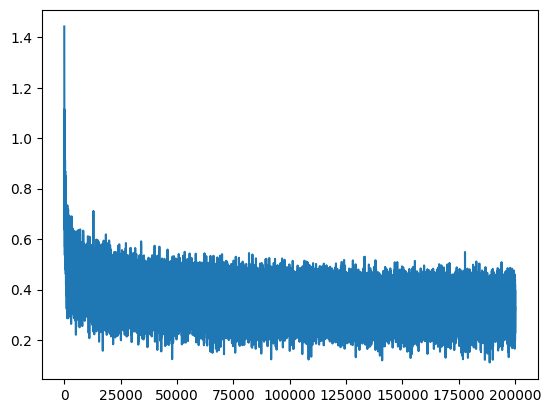

In [28]:
plt.plot(stepi, lossi)

In [30]:
def prompt(cx, max_length=15, samples=1):
  for x in range(samples):
    out = [stoi[c] for c in cx]
    if len(cx) > block_size:
      cx = cx[-block_size:]
    context = [0]*(block_size - len(cx)) + out
    while True:
      emb = C[context]
      wi1 = emb.view(-1, block_size * n_embd) @ w1
      wi1b = wi1 + b1
      wi1ba = wi1b.tanh()
      wi2 = wi1ba @ w2
      logits = wi2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))

prompt("bro", samples=10)

brooklynn.
bronleyema.
bronikko.
bron.
broin.
broden.
brooklett.
bron.
broolynn.
brooen.


In [31]:
prompt("z", samples=10)

zaberve.
zan.
zyn.
zey.
zar.
zanisa.
zay.
zajtane.
zatt.
zandra.


In [32]:
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[context]
    wi1 = emb.view(-1, block_size * n_embd) @ w1
    wi1b = wi1 + b1
    wi1ba = wi1b.tanh()
    wi2 = wi1ba @ w2
    logits = wi2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

gaspene.
mabrigsls.
azemda.
nanon.
anni.
anga.
aat.
eas.
amercermoju.
addi.
dayde.
najerregk.
aareand.
janxon.
jaxtha.
jamane.
mastien.
angelynn.
alexe.
zaan.


In [33]:
prompt('z', samples=10)
print('\n')
prompt('w', samples=10)

zayrittaida.
zakaremontriah.
zuly.
zamiki.
zavianna.
zamars.
zanniella.
zarvon.
zanna.
zad.


wend.
whanna.
wardoni.
wabell.
weson.
whanylon.
wer.
wen.
wretton.
wose.


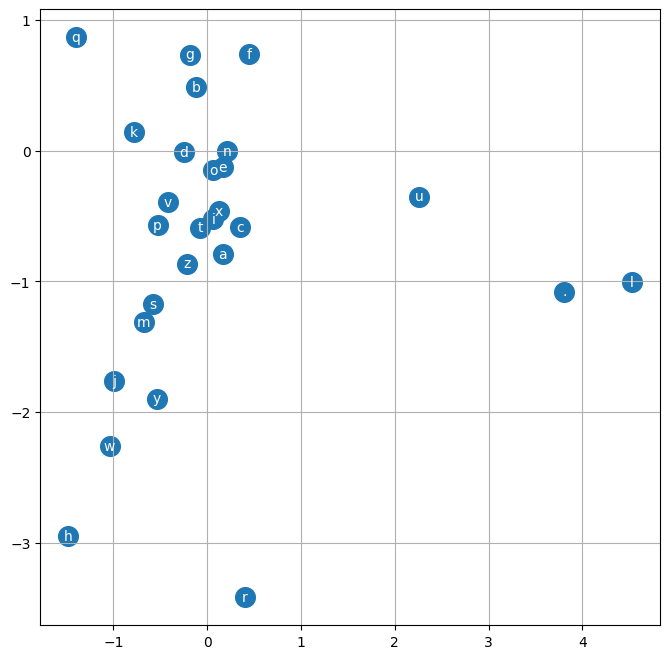

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

thought it was overfitting for a second there

In [ ]:
torch.randint(0, X.shape[0], (32,))

tensor([213172,  33749, 118165, 118634, 212100,  75679,  20942,   7685, 159424,
        104630, 193800, 190421,  69472,  14163,  65536,   7638,  74692,  55967,
         18268, 151616,  68461,  73037, 130511, 196220,  25284, 118811,  17529,
         98684, 158170,  21724,  96713,  95438])

In [ ]:
# train, val, test split
# 80%, 10%, 10%
